In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
env = gym.make("MsPacman-ramDeterministic-v4")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [3]:
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

print(device)

mps


In [4]:
Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward')
)


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
observation_space = env.observation_space
action_space = env.action_space
reward_range = env.reward_range

print(f"Observation space:\n{observation_space}")
print(f"Action space:\n{action_space}")
print(f"Reward range:\n{reward_range}")

Observation space:
Box(0, 255, (128,), uint8)
Action space:
Discrete(9)
Reward range:
(-inf, inf)


In [6]:
class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()

        self.linear_layer1 = nn.Linear(128, 256)
        self.linear_layer2 = nn.Linear(256, n_actions)

    def forward(self, x):
        x = F.relu(self.linear_layer1(x))

        return self.linear_layer2(x)

In [7]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.005
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_actions).to(device)
policy_net.load_state_dict(torch.load('./torch_ram_model/policy_model_weights_best_1.pth', weights_only=True))

target_net = DQN(n_actions).to(device)
target_net.load_state_dict(torch.load('./torch_ram_model/target_model_weights_best_1.pth', weights_only=True))

# target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state, inference=False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold or inference:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []
rewards = []
losses = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 3:
        means = durations_t.unfold(0, 3, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(2), means))
        plt.plot(means.numpy())

    plt.pause(100)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def plot_rewards(rewards, show_result=False):
    plt.figure(1)
    rewards = torch.tensor(rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards) >= 10:
        means = rewards.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(2), means))
        plt.plot(means.numpy())

    plt.pause(3)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    # torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss

100%|██████████| 1000/1000 [2:40:41<00:00,  9.64s/it]

Complete


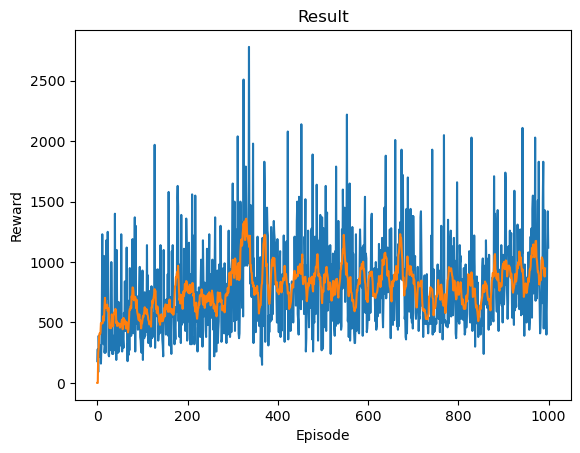

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
num_episodes = 1000
best_reward = 1500

for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    total_loss = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        if done and total_reward > best_reward and i_episode > num_episodes/2:
            torch.save(policy_net.state_dict(), './torch_ram_model/policy_model_weights_best.pth')
            torch.save(target_net.state_dict(), './torch_ram_model/target_model_weights_best.pth')

            best_reward = total_reward

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model()
        if loss:
            total_loss += loss

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            rewards.append(total_reward)
            losses.append(total_loss)
            print(f"total_reward: {total_reward}")
            print(f"total_loss: {total_loss}")
            print(f"steps_done: {steps_done}")
            plot_rewards(rewards=rewards)
            break

print('Complete')
plot_rewards(rewards=rewards, show_result=True)
plt.ioff()
plt.show()

In [ ]:
torch.save(policy_net.state_dict(), './torch_ram_model/policy_model_weights.pth')

In [ ]:
torch.save(target_net.state_dict(), './torch_ram_model/target_model_weights.pth')

In [8]:
env = gym.make("MsPacman-ramDeterministic-v4", render_mode="human")

# making the script reproducible
seed = 0
random.seed(seed)
# env.seed(seed)

print(f'Action Space: {env.action_space}\n')
print(f'Observation Space: {env.observation_space}')

# run 10 episodes in a row
episodes = 3
for i in range(episodes):
    state = env.reset()[0]
    reward_sum = 0

    while True:
        env.render()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action(state, inference=True)
        action = action.item()
        state, reward, done, trunc, info = env.step(action)
        reward_sum += reward
        if done:
            print(f'Episode {i} reward: {reward_sum}')
            break

env.close()

Action Space: Discrete(9)

Observation Space: Box(0, 255, (128,), uint8)


/Users/kyrylo/miniforge3/envs/rl_gym/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Episode 0 reward: 1250.0


: 